# Определение стоимости автомобилей

## Цель исследования и план работ

**Задача**  

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных**  

*Признаки*  
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя  

*Целевой признак*  
- Price — цена (евро)  

**План работы**

1) Загрузка данных.   
2) Обзор и предобработка данных: заполним пропущенные значения и обработаем аномалии в столбцах. Если среди признаков имеются неинформативные, удалим их.  
3) Подготовка выборки для обучения моделей.  
4) Обучение разных моделей, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуем разные гиперпараметры.  
5) Проанализируем время обучения, время предсказания и качество моделей.  
6) Опираясь на критерии заказчика, выберем лучшую модель и проверим её качество на тестовой выборке.

## Подготовка данных

### Обзор данных

Импортируем необходимые библиотеки для проведения исследования.

In [1]:
!pip install missingno

In [2]:
import numpy as np
import pandas as pd
import missingno
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

Загрузим и изучим данные.

In [3]:
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.shape

(354369, 16)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df.describe(include='all')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


**Вывод:**  
1) В датафрейме 354369 объекта, 15 признаков и целевой признак 'price'.    
2) Требуется приведение названий всех столбцов к нижнему регистру и "змеиному" формату.    
3) Требуется изменение типа данных в некоторых столбцах.   
4) В некоторых столбцах есть пропуски. Необходима обработка пропусков.  
5) Необходимо проверить значения признаков на дубликаты и аномалии.  
6) В данных присутствуют категориальные признаки. Требуется их кодирование.  
7) К значимым признакам, которые влияют на стоимость автомобиля, относятся следующие столбцы: 
- VehicleType — тип автомобильного кузова;  
- RegistrationYear — возраст автомобиля в годах влияет на стоимость;  
- Gearbox — тип коробки передач;  
- Power — мощность (л. с.);  
- Model — модель автомобиля;  
- Kilometer — пробег (км);  
- FuelType — тип топлива;  
- Brand — марка автомобиля;  
- Repaired — была машина в ремонте или нет.  

8) Следует удалить неинформативные признаки и исследовать выборку на мультколлинеарность признаков.

### Изменение названий столбцов 

Названия признаков некорректны. Приведем названия всех столбцов к нижнему регистру и "змеиному" формату.

In [7]:
df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### Преобразование типов данных

Преобразуем тип данных столбцов `date_crawled`, `date_created` и `last_seen` из *object* в *datetime*

In [8]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%Y-%m-%d %H:%M:%S')
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%d %H:%M:%S')
df['last_seen'] = pd.to_datetime(df['last_seen'], format='%Y-%m-%d %H:%M:%S')
df[['date_crawled', 'date_created', 'last_seen']].dtypes

date_crawled    datetime64[ns]
date_created    datetime64[ns]
last_seen       datetime64[ns]
dtype: object

### Обработка пропусков

Визуализируем количество порпусков по столбцам.

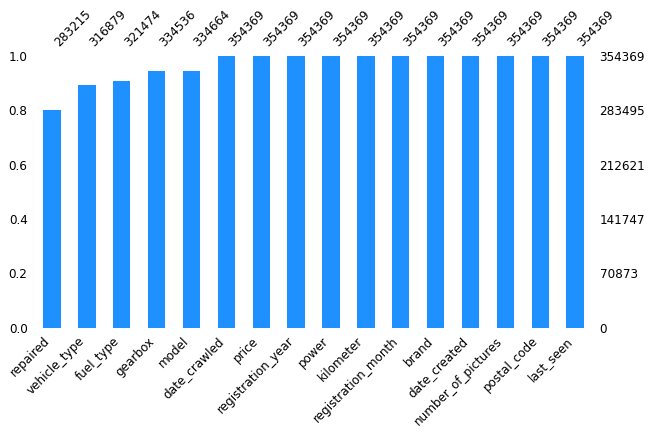

In [9]:
missingno.bar(df, color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12);

Пропуски присутствуют в важных для обучения модели признаках `repaired`, `vehicle_type`, `fuel_type`, `gearbox`, `model`.

- Столбец `repaired`

In [10]:
df['repaired'].isna().sum() / len(df)

0.20079070121822168

В столбце `repaired` отсутствует 20% данных - это существенно.

In [11]:
df['repaired'].value_counts(normalize=True)

no     0.872697
yes    0.127303
Name: repaired, dtype: float64

В 87% процентах объектов столбец `repaired` заполнен значением `no`. Заполним пропуски наиболее часто встречающимся значением `no`, так как нет способа достоверно восстановить отсутствующую информацию на основе других параметров объекта.

In [12]:
df['repaired'] = df['repaired'].fillna('no')

- Столбцы `vehicle_type`, `fuel_type`, `gearbox`, `model`.

Так как солбец `brand` не имеет пропусков, заполним отсутствующие значения столбцов `vehicle_type`, `fuel_type`, `gearbox`, `model` самым часто встречающимся значением по бренду. Перед заполнением выведем на экран строки с пропусками, чтобы проверить результат после заполнения.

In [13]:
features_with_na = ['vehicle_type', 'fuel_type', 'gearbox', 'model'] #список признаков с пропусками
missing_values_examples = df.loc[df.isna().any(axis=1), features_with_na].head()
missing_values_examples

,vehicle_type,fuel_type,gearbox,model
0,NaN,petrol,manual,golf
1,coupe,gasoline,manual,NaN
9,small,NaN,manual,golf
13,wagon,NaN,manual,passat
15,small,petrol,NaN,ka


In [14]:
for feature in features_with_na:
    #для каждого признака создаем сводную таблицу с количеством каждого значения признака для каждого бренда
    feature_by_brand = df.pivot_table(index='brand', columns=feature, values='price', aggfunc='count')
    #для каждого бренда выбираем строки датафрейма по признаку и заполняем отсутствующие значения самым частым значением признака по бренду
    for brand in feature_by_brand.index:
        df.loc[df['brand'] == brand, feature] = df.loc[df['brand'] == brand, feature].fillna(feature_by_brand.loc[brand].idxmax())

Посмотрим на результат заполнения пропусков.

In [15]:
df.loc[missing_values_examples.index, features_with_na]

,vehicle_type,fuel_type,gearbox,model
0,sedan,petrol,manual,golf
1,coupe,gasoline,manual,a4
9,small,petrol,manual,golf
13,wagon,petrol,manual,passat
15,small,petrol,manual,ka


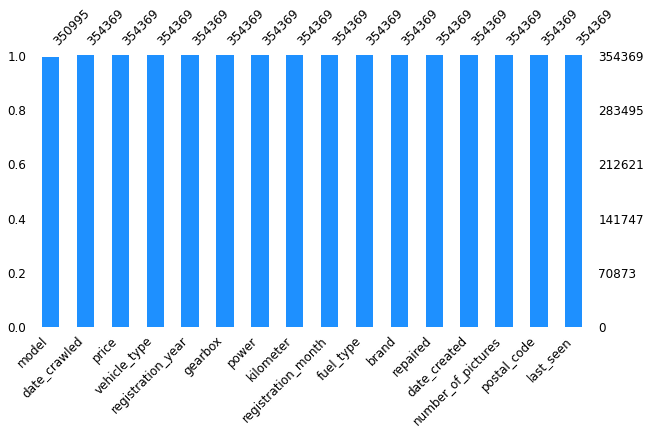

In [16]:
missingno.bar(df, color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12);

В столбце `model` остались незаполненные значения. Избавимся от этих строк с пропусками.

In [17]:
df = df.dropna()
df.shape

(350995, 16)

**Вывод:**  
1) Пропуски в столбце `repaired` были заполнены самым часто встречающимся значением `no` ;  
2) Пропуски в столбцах `vehicle_type`, `fuel_type`, `gearbox`, `model` были заполнены самым часто встречающимся значением по бренду.  
3) 3374 строки с пропусками в столбце `model`, которые не удалось заполнить, были удалены.

### Обработка дубликатов

Проверим датафрейм на дубликаты строк.

In [18]:
print(f'В таблице {df.duplicated().sum()} дубликатов строк.')

В таблице 5 дубликатов строк.


Удалим дубликаты строк.

In [19]:
df = df.drop_duplicates().reset_index(drop=True)
print(f'В таблице {df.duplicated().sum()} дубликатов строк.')

В таблице 0 дубликатов строк.


In [20]:
df.shape

(350990, 16)

Проверим категориальные признаки на наличие явных и неявных дубликатов.

In [21]:
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
for cat_feature in cat_features:
    print(f'Уникальные значения признака {cat_feature}:')
    print(sorted(df[cat_feature].astype('str').unique()))
    print()

Уникальные значения признака vehicle_type:
['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon']

Уникальные значения признака gearbox:
['auto', 'manual']

Уникальные значения признака model:
['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', 'de

В столбце `fuel_type` присутствует неявный дубликат: значения gasoline и petrol - одно и то же. Заменим все значения petrol на gasoline.

In [22]:
df['fuel_type'] = df['fuel_type'].replace(to_replace='petrol', value='gasoline')
sorted(df['fuel_type'].unique())

['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other']

**Вывод:**  
1) Из таблицы удалено 5 дубликатов строк;  
2) в столбце `fuel_type` обнаружены и исправлены неявные дубликаты.

### Обработка аномальных значений

- Столбец `price`

In [23]:
df['price'].describe()

count    350990.000000
mean       4410.797533
std        4503.346994
min           0.000000
25%        1099.000000
50%        2700.000000
75%        6399.000000
max       20000.000000
Name: price, dtype: float64

В столбце `price` среднее смещено вверх по отношению к медиане, значит есть аномальные выбросы значений. Также видим, что минимальное значение цены 0, что также является аномалией.

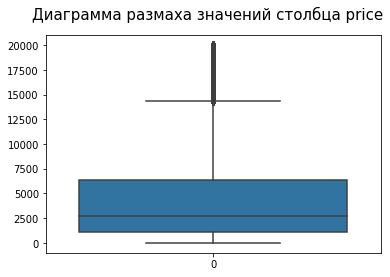

In [24]:
sns.boxplot(data=df['price'])
plt.suptitle('Диаграмма размаха значений столбца price', fontsize=15);

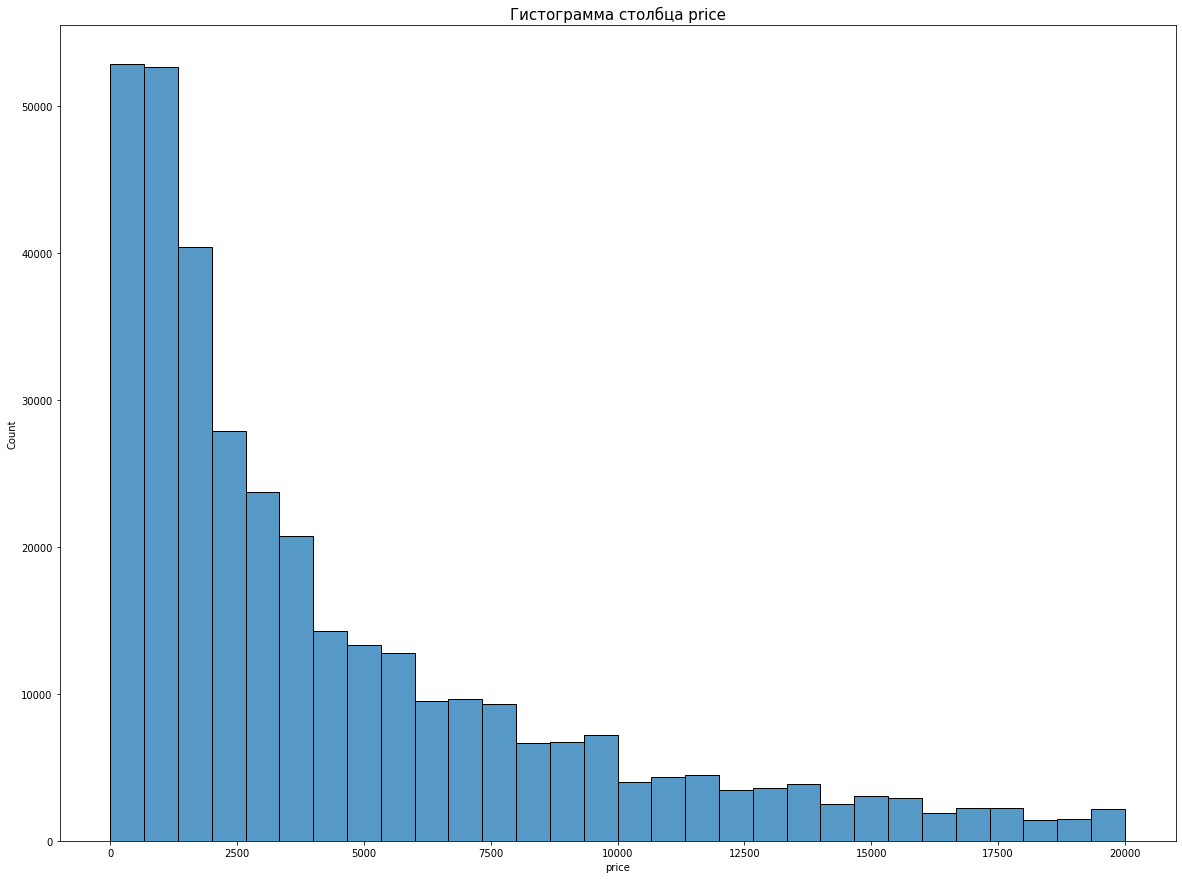

In [25]:
plt.figure(figsize=(20,15))
plt.title('Гистограмма столбца price', fontsize=15);
sns.histplot(data=df['price'], bins=30);

Подберём такие квантили распределения значений цены, чтобы отсечь аномальные значения и выбросы.

In [26]:
def check_price_quantiles(q_lower, q_upper):
    """
    Функция принимает значения вернего и нижнего квантиля и выводит на экран их значения, фильтрует датасет, 
    отсекая значения под нижним и над верхним квантилем, выводит на экран диаграмму размаха и характерные значения
    получившегося датасета.
    """
    price_quantiles = df['price'].quantile([q_lower, q_upper])
    print(price_quantiles)
    print()
    df_filtered = df.loc[(df['price'] >= price_quantiles.loc[q_lower]) & (df['price'] <= price_quantiles.loc[q_upper])]
    sns.boxplot(data=df_filtered['price'])
    plt.suptitle('Диаграмма размаха значений столбца price', fontsize=15);
    print(df_filtered['price'].describe())

Посмотрим 5% и 95% квантили.

0.05      200.0
0.95    14500.0
Name: price, dtype: float64

count    316713.000000
mean       3943.483346
std        3504.649888
min         200.000000
25%        1200.000000
50%        2700.000000
75%        5850.000000
max       14500.000000
Name: price, dtype: float64


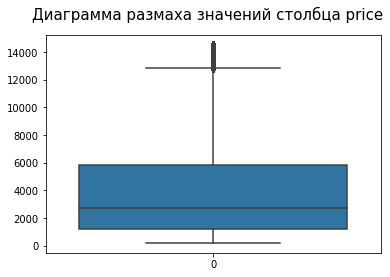

In [27]:
check_price_quantiles(.05, .95)

Нижняя граница цены в 200 евро видится адекватной. Верхняя граница в 14600 евро. Среднее значение всё ещё сильно смещено вверх. Подберем такую верхнюю границу, чтобы избавиться от выбросов в распределении.

0.05      200.0
0.90    11400.0
Name: price, dtype: float64

count    299228.000000
mean       3420.435437
std        2827.579207
min         200.000000
25%        1150.000000
50%        2500.000000
75%        5000.000000
max       11400.000000
Name: price, dtype: float64


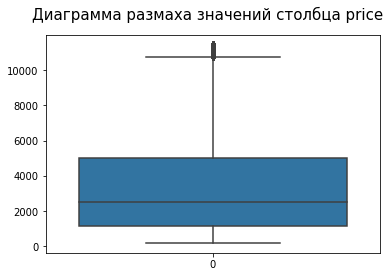

In [28]:
check_price_quantiles(.05, .90)

0.05     200.0
0.85    9000.0
Name: price, dtype: float64

count    282137.000000
mean       3011.710747
std        2352.044128
min         200.000000
25%        1050.000000
50%        2300.000000
75%        4500.000000
max        9000.000000
Name: price, dtype: float64


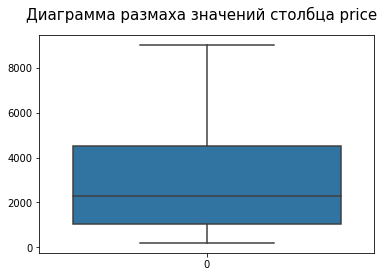

In [29]:
check_price_quantiles(.05, .85)

При верхней границе в 9000 евро распределение избавилось от выбросов. Отфильтруем наш датафрейм по значению цены для 5% и 85% квантиля.

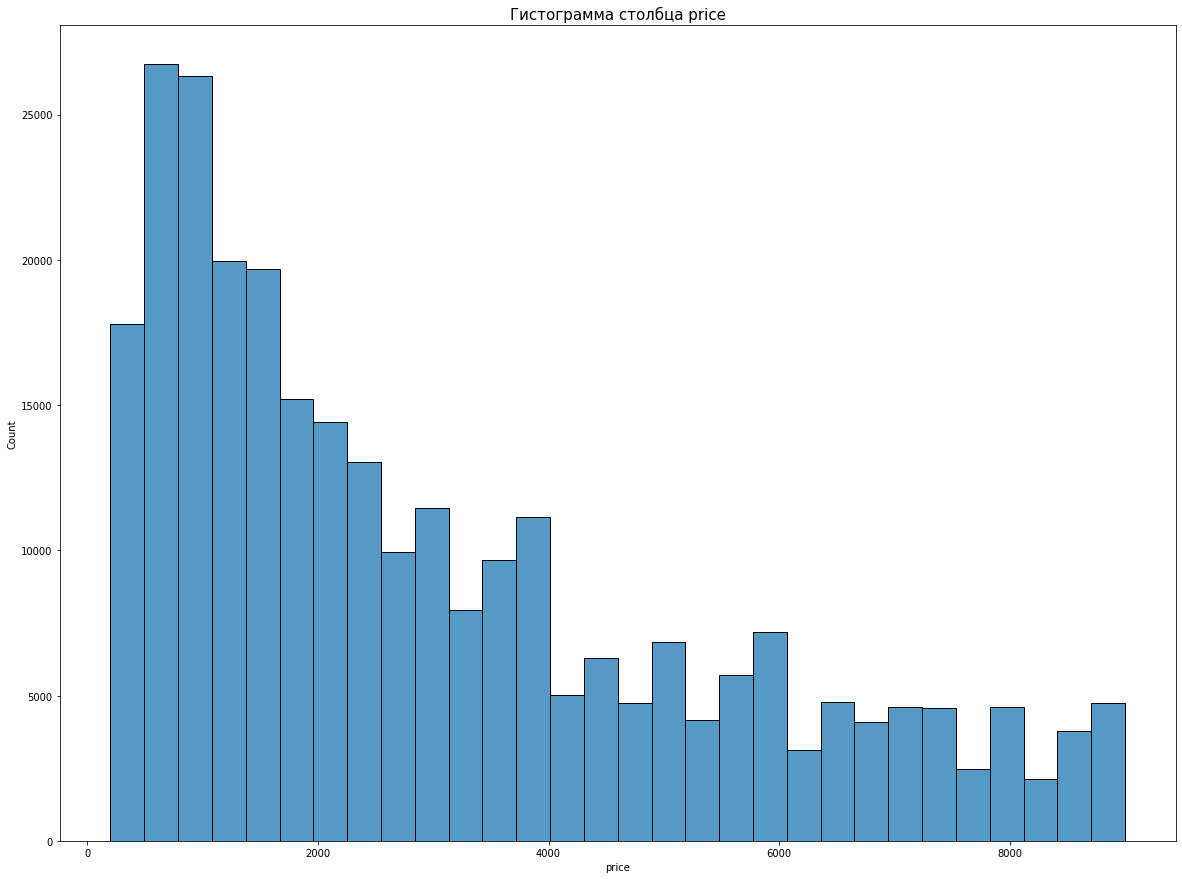

In [30]:
df = df.loc[(df['price'] >= df['price'].quantile([.05, .85]).loc[0.05]) & 
            (df['price'] <= df['price'].quantile([.05, .85]).loc[0.85])]
plt.figure(figsize=(20,15))
plt.title('Гистограмма столбца price', fontsize=15);
sns.histplot(data=df['price'], bins=30);

In [31]:
df.shape

(282137, 16)

- Столбец `registration_year`

Посмотрим за какие года в данных присутствуют объявления по столбцу `date_created`.

In [32]:
pd.DatetimeIndex(df['date_created']).year.value_counts()

2016    282119
2015        17
2014         1
Name: date_created, dtype: int64

Посмотрим характерные значения столбца `registration_year`.

In [33]:
df['registration_year'].describe()

count    282137.000000
mean       2002.935492
std          58.163315
min        1000.000000
25%        1999.000000
50%        2002.000000
75%        2006.000000
max        9999.000000
Name: registration_year, dtype: float64

In [34]:
sorted(df['registration_year'].unique())

[1000,
 1001,
 1039,
 1111,
 1234,
 1300,
 1400,
 1500,
 1600,
 1602,
 1800,
 1910,
 1923,
 1928,
 1930,
 1931,
 1932,
 1934,
 1936,
 1937,
 1938,
 1942,
 1943,
 1945,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2066,
 2200,
 2290,
 2500,
 2800,
 2900,
 3000,
 3700,
 4000,
 4500,
 5000,
 5555,
 5900,
 5911,
 6000,
 7100,
 8200,
 8500,
 9000,
 9999]

Видим, что в столбце `registration_year` много некорректных значений года регистрации. Посмотрим самую позднюю дату регистрации объявления.

In [35]:
df['date_created'].max()

Timestamp('2016-04-07 00:00:00')

Дата регистрации автомобиля не может быть позже даты создания анкеты. Отфильтруем датасет по значениям года регистрации от 1910 до 04.2016 и посмотрим на получившееся распределение значений столбца `registration_year`.

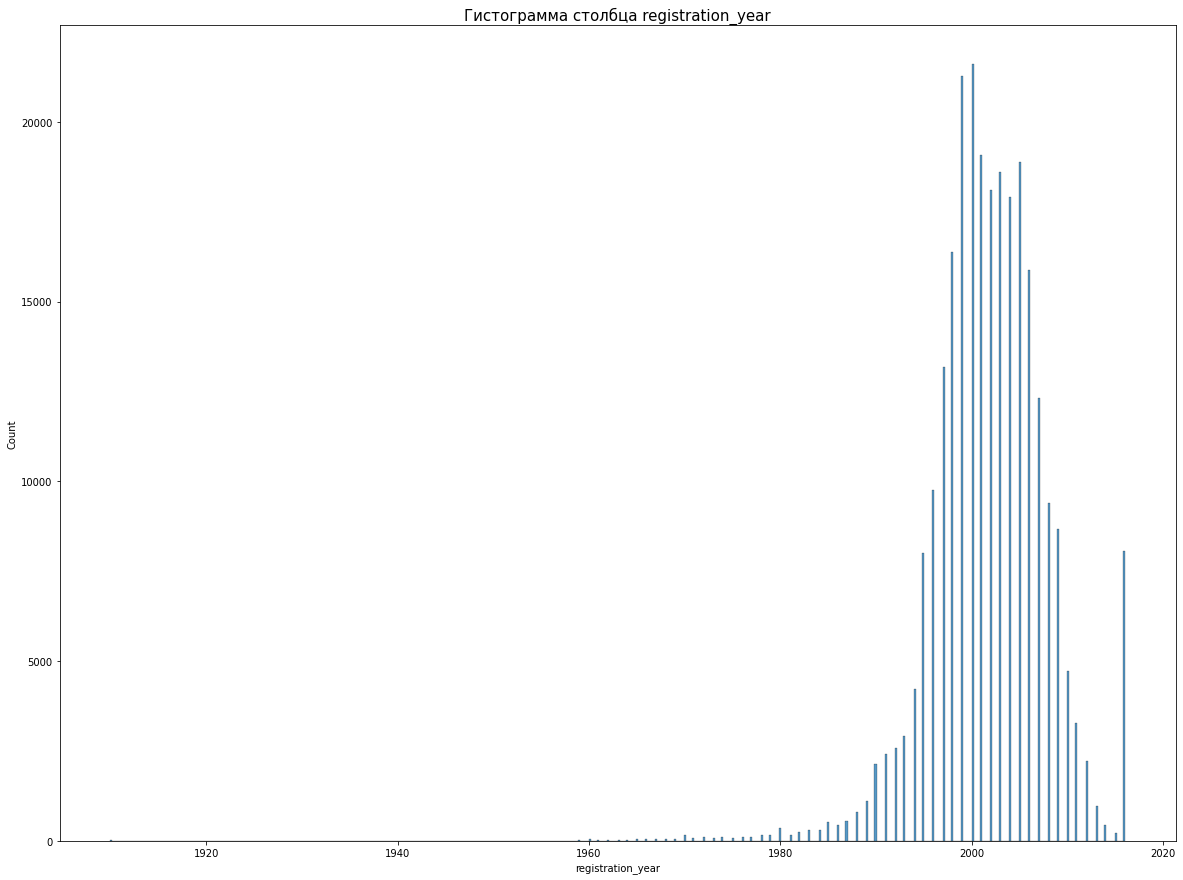

In [36]:
df = df.loc[(df['registration_year'] >= 1910) & (df['registration_year'] < 2017)]
plt.figure(figsize=(20,15))
plt.title('Гистограмма столбца registration_year', fontsize=15);
sns.histplot(data=df['registration_year']);

Отсечём все объекты старше 1960 года.

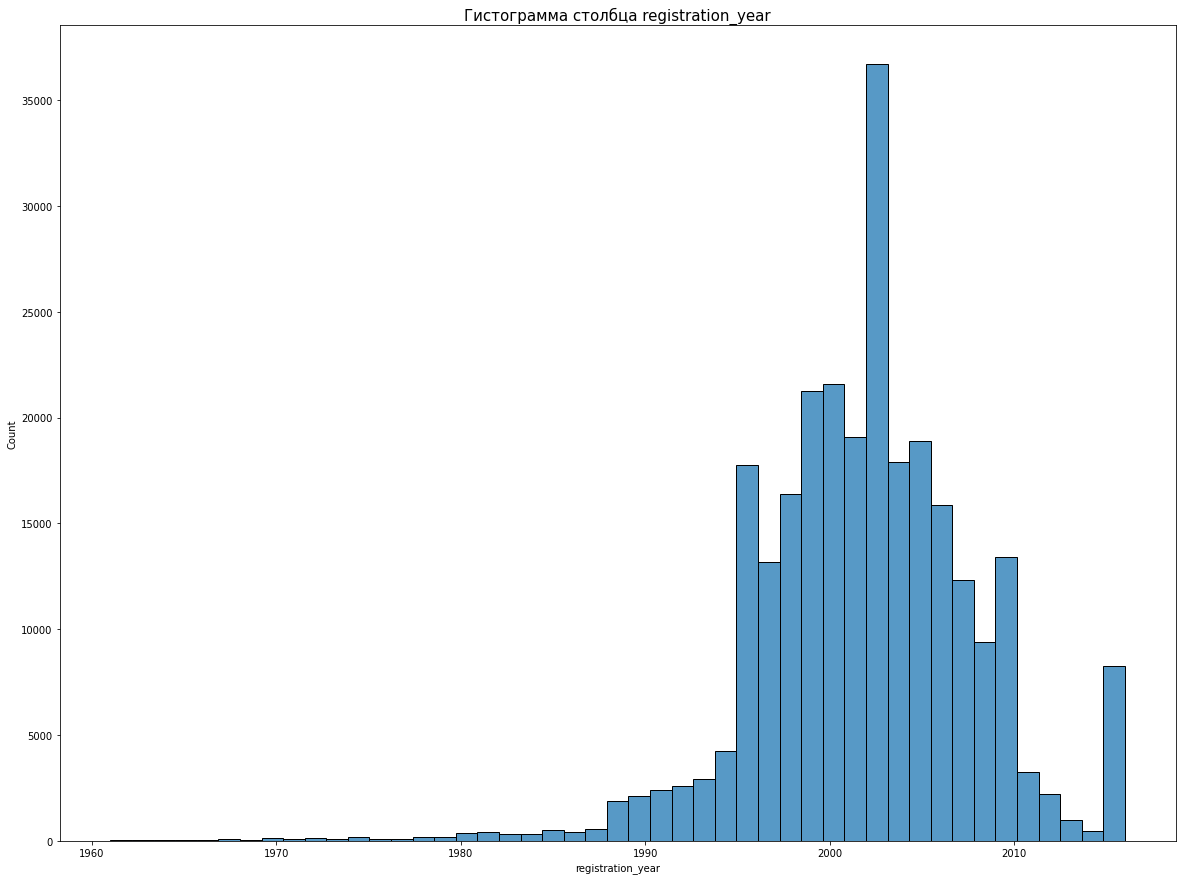

In [37]:
df = df.loc[df['registration_year'] > 1960]
plt.figure(figsize=(20,15))
plt.title('Гистограмма столбца registration_year', fontsize=15);
sns.histplot(data=df['registration_year'], bins=47);

In [38]:
df.shape

(269453, 16)

- Столбец `kilometer`

In [39]:
df['kilometer'].describe()

count    269453.000000
mean     133561.363206
std       32690.244665
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

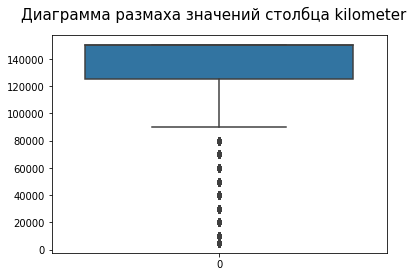

In [40]:
sns.boxplot(data=df['kilometer'])
plt.suptitle('Диаграмма размаха значений столбца kilometer', fontsize=15);

Видим, что большая часть объектов - с пробегами 150000. Присутствуют единичные выбросы значений менее 90000, но их мало и это адекватные значения.

- Столбец `power`

In [41]:
df['power'].describe()

count    269453.000000
mean        102.994210
std         176.749685
min           0.000000
25%          67.000000
50%         101.000000
75%         136.000000
max       20000.000000
Name: power, dtype: float64

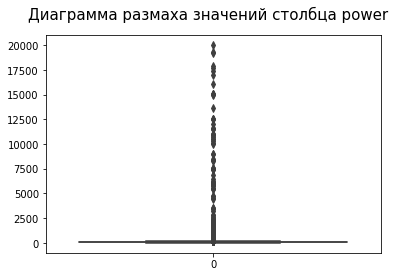

In [42]:
sns.boxplot(data=df['power'])
plt.suptitle('Диаграмма размаха значений столбца power', fontsize=15);

In [43]:
df['power'].value_counts()

0       27888
75      21315
60      14028
101     12055
150     11829
        ...  
1707        1
353         1
6062        1
1120        1
584         1
Name: power, Length: 589, dtype: int64

В столбце присутсвтует большое количество значений 0 и аномально больших значений мощности двигателя. Объекты с нулевым значением придётся удалить из датасета. Посмотрим на значения больше 1000. Возможно владелец в анкете приписал лишний ноль или не поставил точку в числе.

Посмотрим на значения больше 1000. Возможно владелец в анкете приписал лишний ноль или не поставил точку в числе.

In [44]:
df.query('power > 1000').head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
1800,2016-03-22 20:52:00,3200,small,2004,manual,1398,corolla,5000,6,gasoline,toyota,no,2016-03-22,0,22043,2016-03-22 21:43:26
5278,2016-03-29 19:44:48,500,wagon,1999,manual,1001,astra,150000,7,gasoline,opel,no,2016-03-29,0,33154,2016-04-06 05:44:36
7589,2016-04-02 19:25:25,1499,small,1999,manual,7515,lupo,150000,4,gasoline,volkswagen,no,2016-04-02,0,65830,2016-04-06 11:46:49
7648,2016-04-02 11:48:54,1500,small,2000,manual,1400,civic,150000,0,gasoline,honda,no,2016-04-02,0,21509,2016-04-04 09:15:26
9577,2016-03-14 20:06:19,2599,small,2016,manual,1779,zafira,150000,0,gasoline,opel,no,2016-03-14,0,60326,2016-04-07 09:45:27


Возьмем первый объект из списка и посмотрим другие объекты из датасета, совпадающие по полям brand, model и vehicle_type.

In [45]:
df.query("brand == 'toyota' and model == 'corolla' and vehicle_type == 'small'")

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
1076,2016-03-30 07:37:04,1400,small,1989,manual,0,corolla,150000,0,gasoline,toyota,no,2016-03-30,0,73329,2016-04-07 00:15:54
1800,2016-03-22 20:52:00,3200,small,2004,manual,1398,corolla,5000,6,gasoline,toyota,no,2016-03-22,0,22043,2016-03-22 21:43:26
5175,2016-03-15 15:37:04,1000,small,2003,manual,97,corolla,150000,4,gasoline,toyota,yes,2016-03-15,0,60385,2016-04-06 07:16:59
10887,2016-03-27 14:54:10,2500,small,1996,manual,75,corolla,125000,8,gasoline,toyota,no,2016-03-27,0,15738,2016-03-27 14:54:10
18721,2016-03-20 17:52:32,2250,small,2000,manual,110,corolla,100000,12,gasoline,toyota,no,2016-03-20,0,1968,2016-04-07 00:46:22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325094,2016-03-12 02:36:54,1400,small,1997,manual,0,corolla,125000,3,gasoline,toyota,no,2016-03-12,0,47441,2016-04-05 20:46:07
340763,2016-03-23 14:47:22,950,small,2000,manual,63,corolla,150000,8,gasoline,toyota,no,2016-03-23,0,18109,2016-04-05 16:44:45
341739,2016-03-15 15:53:57,650,small,1995,manual,0,corolla,5000,0,gasoline,toyota,no,2016-03-15,0,28717,2016-03-17 11:18:44
347769,2016-03-14 19:41:19,4699,small,2006,manual,110,corolla,90000,4,gasoline,toyota,no,2016-03-14,0,57319,2016-03-28 04:46:53


К сожалению, аномальное значение мощности двигателя 1398 нельзя объяснить ошибкой в разрядности числа. Такие данные придётся просто удалить. Отсечём объекты со значением power < 11 и power > 500 и посмотрим распределение.

In [46]:
df = df.loc[(df['power'] > 10) & (df['power'] <= 500)]

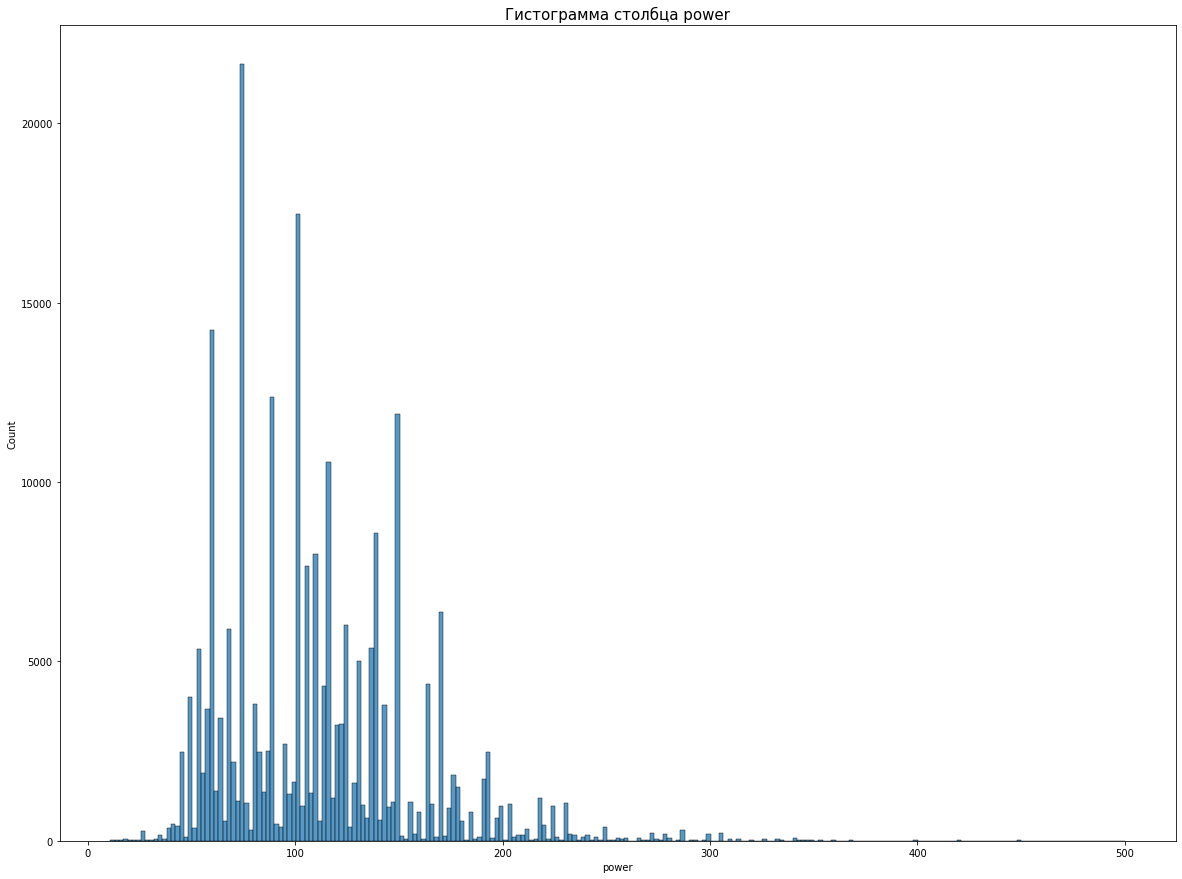

In [47]:
plt.figure(figsize=(20,15))
plt.title('Гистограмма столбца power', fontsize=15);
sns.histplot(data=df['power']);

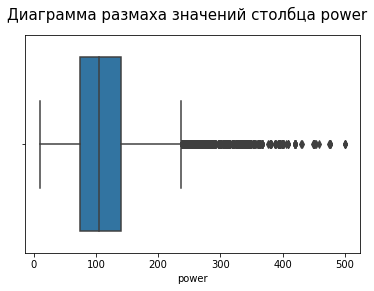

In [48]:
#df.boxplot('power')
sns.boxplot(df['power'])
plt.suptitle('Диаграмма размаха значений столбца power', fontsize=15);

In [49]:
df['power'].describe()

count    241210.000000
mean        111.217002
std          45.768751
min          11.000000
25%          75.000000
50%         105.000000
75%         140.000000
max         500.000000
Name: power, dtype: float64

Посмотрим на объекты с мощностью от 300 до 500 л.с.

In [50]:
df.query('300<=power<=500')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
41,2016-03-30 20:38:20,7500,sedan,2002,auto,306,e_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-30,0,33649,2016-04-03 11:44:49
391,2016-04-01 19:49:57,6250,small,2016,manual,310,astra,150000,0,gasoline,opel,no,2016-04-01,0,58809,2016-04-03 16:47:23
444,2016-04-01 22:51:18,8500,sedan,2003,manual,300,a4,150000,3,gasoline,audi,no,2016-04-01,0,18573,2016-04-05 21:45:11
1185,2016-03-26 19:37:50,5800,sedan,2000,auto,326,7er,150000,3,gasoline,bmw,yes,2016-03-26,0,45549,2016-04-02 11:18:22
1235,2016-03-29 15:53:54,4490,coupe,1984,auto,310,other,150000,4,gasoline,porsche,no,2016-03-29,0,85777,2016-03-29 16:41:57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349347,2016-03-28 12:38:50,6666,sedan,2002,auto,333,7er,150000,8,gasoline,bmw,no,2016-03-28,0,24534,2016-03-31 20:18:54
349732,2016-03-18 12:47:25,8000,sedan,2002,auto,306,c_klasse,150000,12,gasoline,mercedes_benz,no,2016-03-18,0,78239,2016-04-05 22:16:52
350287,2016-04-04 21:55:50,6995,wagon,2004,auto,306,e_klasse,150000,11,lpg,mercedes_benz,no,2016-04-04,0,42489,2016-04-07 00:45:17
350306,2016-03-28 23:45:59,5800,sedan,2000,auto,326,7er,150000,3,gasoline,bmw,yes,2016-03-28,0,45549,2016-04-07 09:45:20


Данные выглядят правдоподобно. Многие модели брендов Mercedez, BMW, Audi имеют мощность двигателя до 500 л.с.

In [51]:
df.shape

(241210, 16)

**Вывод:** в результате обработки аномальных значений в столбцах `price`, `registration_year`, `power` из датасета было удалено 112099 объектов.

### Подготовка признаков

Удалим неинформативные признаки `date_crawled`, `registration_month`, `date_created`, `number_of_pictures`, `postal_code`, `last_seen` из датасета.

In [52]:
df = df.drop(['date_crawled', 'registration_month', 
              'date_created', 'number_of_pictures', 
              'postal_code', 'last_seen'], axis=1)

In [53]:
df.shape

(241210, 10)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241210 entries, 3 to 350989
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              241210 non-null  int64 
 1   vehicle_type       241210 non-null  object
 2   registration_year  241210 non-null  int64 
 3   gearbox            241210 non-null  object
 4   power              241210 non-null  int64 
 5   model              241210 non-null  object
 6   kilometer          241210 non-null  int64 
 7   fuel_type          241210 non-null  object
 8   brand              241210 non-null  object
 9   repaired           241210 non-null  object
dtypes: int64(4), object(6)
memory usage: 20.2+ MB


Проведем исследование выборки на мультиколлинеарность количественных признаков.

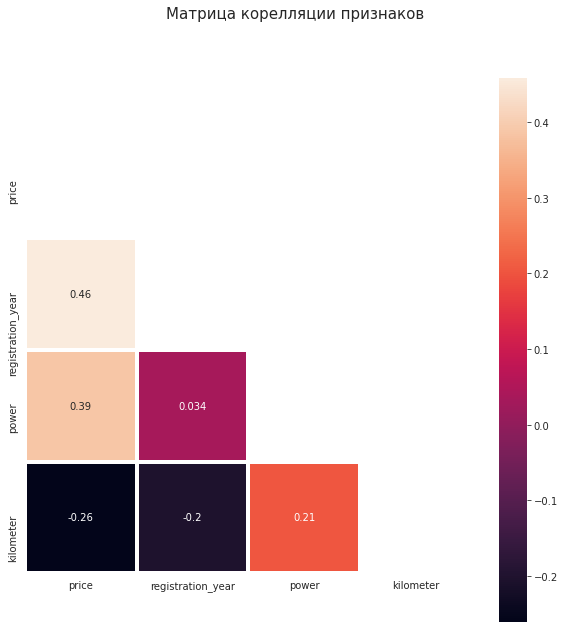

In [55]:
df_corr = df.corr()
mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 10))
    plt.suptitle('Матрица корелляции признаков', fontsize=15);
    ax = sns.heatmap(df_corr, mask=mask, square=True, annot=True, linewidths=3, linecolor='white')

Как видим, тесной взаимосвязи признаков нет. Коэффициент корреляции Пирсона для признаков не превышает 0.21. Можно отметить слабую взаимосвязь признаков и целевого признака `price`. Например, прямая линейная связь между `registration_year` и `price` (чем больше год, т.е. новее машина, тем выше цена), `power` и `price`, отрицательная линейная связь между пробегом и ценой.

In [56]:
df = df.reset_index(drop=True)

Разделим выборку на признаки и целевой признак.

In [57]:
features = df.drop('price', axis=1)
target = df['price']

Разделим исходные данные на обучающую, валидационную и тестовую выборки в соотношении 60% / 20% / 20% соответственно. Валидационную выборку мы будем использовать для анализа моделей, а на тестовой выборке будем проверять качество лучшей модели.

In [58]:
features_train, features_other, target_train, target_other = train_test_split(features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_other, target_other, test_size=0.5, random_state=12345)


In [59]:
features_train.shape, features_valid.shape, features_test.shape

((144726, 9), (48242, 9), (48242, 9))

Осуществим кодирование категориальных признаков двумя разными техниками, так как данные будут использоваться для обучения разных моделей:  
1) прямое кодирование OHЕ для линейной регрессии  
2) порядковое кодирование OЕ для решающего дерева, случайного леса, LightGBM  
3) категориальные данные без кодирования для CatBoost
<a name="example"></a>

In [62]:
# техника прямого кодирования OHE для линейной регрессии
features_ohe = pd.get_dummies(features, drop_first=True)
features_train_ohe = features_ohe.loc[features_train.index, :]
features_valid_ohe = features_ohe.loc[features_valid.index, :]
features_test_ohe = features_ohe.loc[features_test.index, :]


# техника порядкового кодирования OE для решающего дерева, случайного леса и LightGBM.
encoder = OrdinalEncoder()
categorial_features = features[cat_features]
categorial_features = pd.DataFrame(encoder.fit_transform(categorial_features),
                                   columns=categorial_features.columns, 
                                   index=categorial_features.index)
features_oe = features.copy()
for column in cat_features:
    features_oe[column] = categorial_features[column]
    
features_train_oe = features_oe.loc[features_train.index, :]
features_valid_oe = features_oe.loc[features_valid.index, :]
features_test_oe = features_oe.loc[features_test.index, :]

In [63]:
features_train_ohe.shape, features_valid_ohe.shape, features_test_ohe.shape

((144726, 301), (48242, 301), (48242, 301))

In [64]:
features_train_oe.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
113709,5.0,2004,1.0,85,122.0,125000,2.0,11.0,0.0
116200,5.0,2004,1.0,75,119.0,150000,2.0,30.0,0.0
105648,4.0,1994,0.0,286,19.0,150000,4.0,2.0,0.0
114019,4.0,2003,0.0,145,153.0,125000,2.0,10.0,0.0
21904,7.0,2000,1.0,204,95.0,150000,2.0,20.0,1.0


## Обучение моделей

Выберем следующие модели для сравнения:

1) LinearRegression  
2) DecisionTreeRegressor  
3) RandomForestRegressor  
4) CatBoostRegressor  
5) LGBMRegressor

Будем фиксировать время обучения, время предсказания и качество моделей метрикой RMSE.

### LinearRegression 

Приведем численные признаки к одному масштабу, обучим модель и получим метрику качества на валидационной выборке.

In [65]:
numeric = ['registration_year', 'power', 'kilometer']
scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_valid_ohe[numeric] = scaler.transform(features_valid_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

In [66]:
%%time

model = LinearRegression()
model.fit(features_train_ohe, target_train)

CPU times: user 9.36 s, sys: 5.63 s, total: 15 s
Wall time: 16.5 s


LinearRegression()

In [67]:
features_valid_ohe.shape

(48242, 301)

In [68]:
%%time

predict_LR = model.predict(features_valid_ohe)
rmse_LR = mean_squared_error(target_valid, predict_LR) ** 0.5
print(f'RMSE модели линейной регрессии на валидационной выборке: {rmse_LR}')

RMSE модели линейной регрессии на валидационной выборке: 1581.1182551040408
CPU times: user 69.9 ms, sys: 137 ms, total: 207 ms
Wall time: 192 ms


### DecisionTreeRegressor 

Подберем гиперпараметр `max_depth` для модели DecisionTreeRegressor.

In [69]:
%%time

best_result = 10000
best_max_depth = 0
for max_depth in range(2, 21):
    model = DecisionTreeRegressor(random_state=12345, max_depth=max_depth)
    model.fit(features_train_oe, target_train)
    predictions_valid = model.predict(features_valid_oe)
    result = mean_squared_error(target_valid, predictions_valid) ** 0.5
    if result < best_result:
        best_max_depth = max_depth
        best_result = result
print(f'RMSE наилучшей модели на валидационной выборке: {best_result}')
print(f'max_depth: {best_max_depth}')

RMSE наилучшей модели на валидационной выборке: 1146.8093495853225
max_depth: 15
CPU times: user 5.27 s, sys: 13.7 ms, total: 5.29 s
Wall time: 5.3 s


Замерим время обучения и предсказания.

In [70]:
%%time

model = DecisionTreeRegressor(random_state=12345, max_depth=best_max_depth)
model.fit(features_train_oe, target_train)

CPU times: user 348 ms, sys: 3.95 ms, total: 352 ms
Wall time: 361 ms


DecisionTreeRegressor(max_depth=15, random_state=12345)

In [71]:
%%time

predict_DT = model.predict(features_valid_oe)
rmse_DT = mean_squared_error(target_valid, predict_DT) ** 0.5
print(f'RMSE наилучшей модели дерева решений на валидационной выборке: {rmse_DT}')

RMSE наилучшей модели дерева решений на валидационной выборке: 1146.8093495853225
CPU times: user 16.3 ms, sys: 70 µs, total: 16.4 ms
Wall time: 23.4 ms


### RandomForestRegressor

Подберем гиперпараметры `max_depth` и `n_estimators` для модели RandomForestRegressor.

In [72]:
%%time

best_result = 10000
best_max_depth = 0
best_n_estimators = 0
for est in range(10, 51, 10):
    for max_depth in range(2, 21):
        model = RandomForestRegressor(random_state=12345, max_depth=max_depth, n_estimators=est)
        model.fit(features_train_oe, target_train)
        predictions_valid = model.predict(features_valid_oe)
        result = mean_squared_error(target_valid, predictions_valid) ** 0.5
        if result < best_result:
            best_max_depth = max_depth
            best_n_estimators = est
            best_result = result
print(f'RMSE наилучшей модели на валидационной выборке: {best_result}')
print(f'n_estimators: {best_n_estimators}')
print(f'max_depth: {best_max_depth}')

RMSE наилучшей модели на валидационной выборке: 1026.9766657128966
n_estimators: 50
max_depth: 18
CPU times: user 9min, sys: 2.42 s, total: 9min 2s
Wall time: 9min 13s


Замерим время обучения и предсказания.

In [73]:
%%time

model = RandomForestRegressor(random_state=12345, max_depth=best_max_depth, n_estimators=best_n_estimators)
model.fit(features_train_oe, target_train)

CPU times: user 13.8 s, sys: 120 ms, total: 13.9 s
Wall time: 13.9 s


RandomForestRegressor(max_depth=18, n_estimators=50, random_state=12345)

In [74]:
%%time

predict_RF = model.predict(features_valid_oe)
rmse_RF = mean_squared_error(target_valid, predict_RF) ** 0.5
print(f'RMSE наилучшей модели случайного леса на валидационной выборке: {rmse_RF}')

RMSE наилучшей модели случайного леса на валидационной выборке: 1026.9766657128966
CPU times: user 621 ms, sys: 3.96 ms, total: 625 ms
Wall time: 635 ms


### CatBoostRegressor

Подберем гиперпараметры `learning_rate` и `depth` для модели CatBoostRegressor.

In [75]:
%%time

best_result = 10000
best_learning_rate = 0
for learning_rate in np.arange(0.1, 0.6, 0.2):
    model = CatBoostRegressor(loss_function='RMSE', random_state=12345, depth=2, learning_rate=learning_rate)
    model.fit(features_train, target_train, cat_features=cat_features, verbose=False)
    predictions_valid = model.predict(features_valid)
    result = mean_squared_error(target_valid, predictions_valid) ** 0.5
    if result < best_result:
        best_learning_rate = learning_rate
        best_result = result
print(f'RMSE наилучшей модели на валидационной выборке: {best_result}')
print(f'learning_rate: {best_learning_rate}')

RMSE наилучшей модели на валидационной выборке: 1071.315485190527
learning_rate: 0.5000000000000001
CPU times: user 1min 44s, sys: 1.01 s, total: 1min 45s
Wall time: 1min 48s


In [76]:
%%time

best_result = 10000
best_depth = 0
for depth in range(5, 11):
    model = CatBoostRegressor(loss_function='RMSE', random_state=12345, depth=depth, learning_rate=best_learning_rate)
    model.fit(features_train, target_train, cat_features=cat_features, verbose=False)
    predictions_valid = model.predict(features_valid)
    result = mean_squared_error(target_valid, predictions_valid) ** 0.5
    if result < best_result:
        best_depth = depth
        best_result = result
print(f'RMSE наилучшей модели на валидационной выборке: {best_result}')
print(f'depth: {best_depth}')

RMSE наилучшей модели на валидационной выборке: 1013.5656705692915
depth: 7
CPU times: user 15min 43s, sys: 8.23 s, total: 15min 51s
Wall time: 15min 58s


Замерим время обучения и предсказания модели с наилучшими гиперпараметрами.

In [77]:
%%time

model = CatBoostRegressor(loss_function='RMSE', random_state=12345, depth=best_depth, learning_rate=best_learning_rate)
model.fit(features_train, target_train, cat_features=cat_features, verbose=False)

CPU times: user 2min 12s, sys: 629 ms, total: 2min 13s
Wall time: 2min 14s


In [78]:
%%time

predict_CB = model.predict(features_valid)
rmse_CB = mean_squared_error(target_valid, predict_CB) ** 0.5
print(f'RMSE модели CatBoost на валидационной выборке: {rmse_CB}')

RMSE модели CatBoost на валидационной выборке: 1013.5656705692915
CPU times: user 688 ms, sys: 3.95 ms, total: 692 ms
Wall time: 693 ms


Посмотрим качество модели на обучающей выборке, чтобы узнать, не переобучилась ли модель.

In [79]:
%%time

predict_CB_train = model.predict(features_train)
rmse_CB_train = mean_squared_error(target_train, predict_CB_train) ** 0.5
print(f'RMSE модели CatBoost на обучающей выборке выборке: {rmse_CB_train}')

RMSE модели CatBoost на обучающей выборке выборке: 918.2931330764194
CPU times: user 2.04 s, sys: 7.9 ms, total: 2.05 s
Wall time: 2.06 s


### LGBMRegressor

Подберем гиперпараметры `learning_rate` и `max_depth` для модели LGBMRegressor.

In [80]:
%%time

best_result = 10000
best_max_depth = 0
best_learning_rate = 0
for learning_rate in [0.1, 0.5]:
    for depth in [2, 5]:
        model = LGBMRegressor(random_state=12345, max_depth=depth, learning_rate=learning_rate)
        model.fit(features_train_oe, target_train)
        predictions_valid = model.predict(features_valid_oe)
        result = mean_squared_error(target_valid, predictions_valid) ** 0.5
        if result < best_result:
            best_max_depth = depth
            best_learning_rate = learning_rate
            best_result = result
print(f'RMSE наилучшей модели на валидационной выборке: {best_result}')
print(f'learning_rate: {best_learning_rate}')
print(f'max_depth: {best_max_depth}')

RMSE наилучшей модели на валидационной выборке: 1046.7193023247362
learning_rate: 0.5
max_depth: 5
CPU times: user 10min 24s, sys: 6.68 s, total: 10min 30s
Wall time: 10min 38s


Замерим время обучения и предсказания.

In [81]:
%%time

model = LGBMRegressor(random_state=12345, max_depth=best_max_depth, learning_rate=best_learning_rate)
model.fit(features_train_oe, target_train)

CPU times: user 5min, sys: 4.43 s, total: 5min 4s
Wall time: 5min 7s


LGBMRegressor(learning_rate=0.5, max_depth=5, random_state=12345)

In [82]:
%%time

predict_LGBMR = model.predict(features_valid_oe)
rmse_LGBMR  = mean_squared_error(target_valid, predict_LGBMR) ** 0.5
print(f'RMSE модели LGBMRegressor на валидационной выборке: {rmse_LGBMR}')

RMSE модели LGBMRegressor на валидационной выборке: 1046.7193023247362
CPU times: user 385 ms, sys: 0 ns, total: 385 ms
Wall time: 398 ms


Посмотрим качество модели на обучающей выборке, чтобы узнать, не переобучилась ли модель.

In [83]:
%%time

predict_LGBMR_train = model.predict(features_train_oe)
rmse_LGBMR_train = mean_squared_error(target_train, predict_LGBMR_train) ** 0.5
print(f'RMSE модели LGBMRegressor на обучающей выборке выборке: {rmse_LGBMR_train}')

RMSE модели LGBMRegressor на обучающей выборке выборке: 1001.9430304383449
CPU times: user 1.03 s, sys: 29.9 ms, total: 1.06 s
Wall time: 1.08 s


## Анализ моделей

Сведем результаты времени обучения, предсказания и качества моделей в таблицу. Заказчику одинаково важны качество предсказания, скорость предсказания и время обучения. Проставим для каждого из этих параметров рейтинг от 1 до 5, где 5 - самый лучший показатель, а 1 - самый худший, и найдём общий рейтинг как сумму рейтингов трёх показателей.

In [87]:
index = ['LinearRegression',
         'DecisionTreeRegressor',
         'RandomForestRegressor',
         'CatBoostRegressor',
         'LGBMRegressor']
data = {'RMSE_on_validation_set':[rmse_LR,
                                  rmse_DT,
                                  rmse_RF,
                                  rmse_CB,
                                  rmse_LGBMR],
        'Fit_time(s)':[16.5,
                       0.361,
                       13.9,
                       134,
                       307],
        'Predict_time(s)':[0.192,
                           0.023,
                           0.635,
                           0.693,
                           0.398]
       }

scores_data = pd.DataFrame(data=data, index=index)

def set_rating(df, column):
    df = df.sort_values(by=column, ascending=False)
    name = column + '_rating'
    df[name] = [1, 2, 3, 4, 5]
    return df

scores_data = set_rating(scores_data, 'RMSE_on_validation_set')
scores_data = set_rating(scores_data, 'Fit_time(s)')
scores_data = set_rating(scores_data, 'Predict_time(s)')
scores_data['Final_rating'] = (scores_data['RMSE_on_validation_set_rating'] +
                               scores_data['Fit_time(s)_rating'] +
                               scores_data['Predict_time(s)_rating']).round(2)
scores_data = scores_data.sort_values(by='Final_rating', ascending=False)

scores_data

,RMSE_on_validation_set,Fit_time(s),Predict_time(s),RMSE_on_validation_set_rating,Fit_time(s)_rating,Predict_time(s)_rating,Final_rating
DecisionTreeRegressor,1146.809350,0.361,0.023,2,5,5,12
RandomForestRegressor,1026.976666,13.900,0.635,4,4,2,10
CatBoostRegressor,1013.565671,134.000,0.693,5,2,1,8
LinearRegression,1581.118255,16.500,0.192,1,3,4,8
LGBMRegressor,1046.719302,307.000,0.398,3,1,3,7


Опираясь на критерии заказчика, лучшей моделью является модель решающего дерева (DecisionTreeRegressor). Она является лидером по скорости обучения и предсказания, и не значительно уступает по качеству моделям градиентного бустинга.
Проверим качество лучшей модели на тестовой выборке.

In [88]:
%%time

model = DecisionTreeRegressor(random_state=12345, max_depth=15)
model.fit(features_train_oe, target_train)

CPU times: user 348 ms, sys: 16 µs, total: 348 ms
Wall time: 350 ms


DecisionTreeRegressor(max_depth=15, random_state=12345)

In [89]:
%%time

predict_DT_test = model.predict(features_test_oe)
rmse_DT_test = mean_squared_error(target_test, predict_DT_test) ** 0.5
print(f'RMSE модели дерева решений на тестовой выборке: {rmse_DT_test}')

RMSE модели дерева решений на тестовой выборке: 1152.2956029347688
CPU times: user 15.4 ms, sys: 0 ns, total: 15.4 ms
Wall time: 13.7 ms


## Итоги исследования и общий вывод

В данной работе была построена модель для определения рыночной стоимости автомобиля по данным о технических характеристиках, комплектации и ценах других автомобилей. 
Для заказчика были важны следующие критерии модели:  
- качество предсказания;
- время обучения модели;
- время предсказания модели.  

Нам был предоставлен исходный датасет. Мы провели обзор и предподготовку данных, в реультате которых в данных были:   
1) изменены названия признаков на "змеиный" формат;  
2) проеобразован тип данных столбцов `date_crawled`, `date_created` и `last_seen` из *object* в *datetime*;  
3) заполнены пропуски в столбцах `repaired` самым часто встречающимся значением `no` ;  
4) заполнены пропуски в столбцах `vehicle_type`, `fuel_type`, `gearbox`, `model` самым часто встречающимся значением по бренду;  
5) были удалены 3374 строки с пропусками в столбце `model`, которые не удалось заполнить;  
6) удалено 5 дубликатов строк;  
7) обнаружены и исправлены неявные дубликаты в столбце `fuel_type` ;  
8) удалено 112099 объектов результате обработки аномальных значений в столбцах `price`, `registration_year`, `power`.

Далее мы выбрали 5 моделей для сравнения качества по метрике RMSE, времени обучения и предсказания модели:

1) LinearRegression  
2) DecisionTreeRegressor  
3) RandomForestRegressor  
4) CatBoostRegressor  
5) LGBMRegressor

Сравнительный анализ показал, что лучше всего критерии заказчика удовлетворяет модель решающего дерева (DecisionTreeRegressor), которая является лидером по скорости обучения и предсказания, и незначительно уступает по качеству моделям градиентного бустинга. Модель показала приемлемый результат качества на тестовой выборке.